# Notebook for `nowcast` results

Before running this notebook, download the pretrained models as described in the `README`


In [3]:
import os
os.environ["HDF5_USE_FILE_LOCKING"]='FALSE'
import sys
sys.path.append('../src/')
import h5py
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import pandas as pd
from display.display import get_cmap

## Load pretrained models

In [4]:
# Load pretrained nowcasting models
mse_file  = '/Users/priyankashinde/Desktop/neurips-2020-sevir-master/models/mse_model_nowcast.h5'
mse_model = tf.keras.models.load_model(mse_file,compile=False,custom_objects={"tf": tf})

style_file = '/Users/priyankashinde/Desktop/neurips-2020-sevir-master/models/style_model_nowcast.h5'
style_model = tf.keras.models.load_model(style_file,compile=False,custom_objects={"tf": tf})

mse_style_file = '/Users/priyankashinde/Desktop/neurips-2020-sevir-master/models/mse_and_style_nowcast.h5'
mse_style_model = tf.keras.models.load_model(mse_style_file,compile=False,custom_objects={"tf": tf})

gan_file = '/Users/priyankashinde/Desktop/neurips-2020-sevir-master/models/gan_generator_nowcast.h5'
gan_model = tf.keras.models.load_model(gan_file,compile=False,custom_objects={"tf": tf})

## Load sample test data

To download sample test data, go to https://www.dropbox.com/s/27pqogywg75as5f/nowcast_testing.h5?dl=0
 and save file to `data/sample/nowcast_testing.h5`


In [5]:
# Load a part of the test dataset
from readers.nowcast_reader import read_data
x_test,y_test = read_data('nowcast_testing.h5',end=50)

## Plot samples for test set

In [4]:
## 
# Functions for plotting results
##

norm = {'scale':47.54,'shift':33.44}
hmf_colors = np.array( [
    [82,82,82], 
    [252,141,89],
    [255,255,191],
    [145,191,219]
])/255

# Model that implements persistence forecast that just repeasts last frame of input
class persistence:
    def predict(self,x_test):
        return np.tile(x_test[:,:,:,-1:],[1,1,1,12])

def plot_hit_miss_fa(ax,y_true,y_pred,thres):
    mask = np.zeros_like(y_true)
    mask[np.logical_and(y_true>=thres,y_pred>=thres)]=4
    mask[np.logical_and(y_true>=thres,y_pred<thres)]=3
    mask[np.logical_and(y_true<thres,y_pred>=thres)]=2
    mask[np.logical_and(y_true<thres,y_pred<thres)]=1
    cmap=ListedColormap(hmf_colors)
    ax.imshow(mask,cmap=cmap)


def visualize_result(models,x_test,y_test,idx,ax,labels):
    fs=10
    cmap_dict = lambda s: {'cmap':get_cmap(s,encoded=True)[0],
                           'norm':get_cmap(s,encoded=True)[1],
                           'vmin':get_cmap(s,encoded=True)[2],
                           'vmax':get_cmap(s,encoded=True)[3]}
    for i in range(1,13,3):
        xt = x_test[idx,:,:,i]*norm['scale']+norm['shift']
        ax[(i-1)//3][0].imshow(xt,**cmap_dict('vil'))
    ax[0][0].set_title('Inputs',fontsize=fs)
    
    pers = persistence().predict(x_test[idx:idx+1])
    pers = pers*norm['scale']+norm['shift']
    x_test = x_test[idx:idx+1]
    y_test = y_test[idx:idx+1]*norm['scale']+norm['shift']
    y_preds=[]
    for i,m in enumerate(models):
        yp = m.predict(x_test)
        if isinstance(yp,(list,)):
            yp=yp[0]
        y_preds.append(yp*norm['scale']+norm['shift'])
    
    for i in range(0,12,3):
        ax[i//3][2].imshow(y_test[0,:,:,i],**cmap_dict('vil'))
    ax[0][2].set_title('Target',fontsize=fs)
    
    # Plot Persistence
    for i in range(0,12,3):
        plot_hit_miss_fa(ax[i//3][4],y_test[0,:,:,i],pers[0,:,:,i],74)
    ax[0][4].set_title('Persistence\nScores',fontsize=fs)
    
    for k,m in enumerate(models):
        for i in range(0,12,3):
            ax[i//3][5+2*k].imshow(y_preds[k][0,:,:,i],**cmap_dict('vil'))
            plot_hit_miss_fa(ax[i//3][5+2*k+1],y_test[0,:,:,i],y_preds[k][0,:,:,i],74)

        ax[0][5+2*k].set_title(labels[k],fontsize=fs)
        ax[0][5+2*k+1].set_title(labels[k]+'\nScores',fontsize=fs)
        
    for j in range(len(ax)):
        for i in range(len(ax[j])):
            ax[j][i].xaxis.set_ticks([])
            ax[j][i].yaxis.set_ticks([])
    for i in range(4):
        ax[i][1].set_visible(False)
    for i in range(4):
        ax[i][3].set_visible(False)
    ax[0][0].set_ylabel('-45 Minutes')
    ax[1][0].set_ylabel('-30 Minutes')
    ax[2][0].set_ylabel('-15 Minutes')
    ax[3][0].set_ylabel('  0 Minutes')
    ax[0][2].set_ylabel('+15 Minutes')
    ax[1][2].set_ylabel('+30 Minutes')
    ax[2][2].set_ylabel('+45 Minutes')
    ax[3][2].set_ylabel('+60 Minutes')
    
    legend_elements = [Patch(facecolor=hmf_colors[1], edgecolor='k', label='False Alarm'),
                   Patch(facecolor=hmf_colors[2], edgecolor='k', label='Miss'),
                   Patch(facecolor=hmf_colors[3], edgecolor='k', label='Hit')]
    ax[-1][-1].legend(handles=legend_elements, loc='lower right', bbox_to_anchor= (-5.4, -.35), 
                           ncol=5, borderaxespad=0, frameon=False, fontsize='16')
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    

### Plot a few test cases

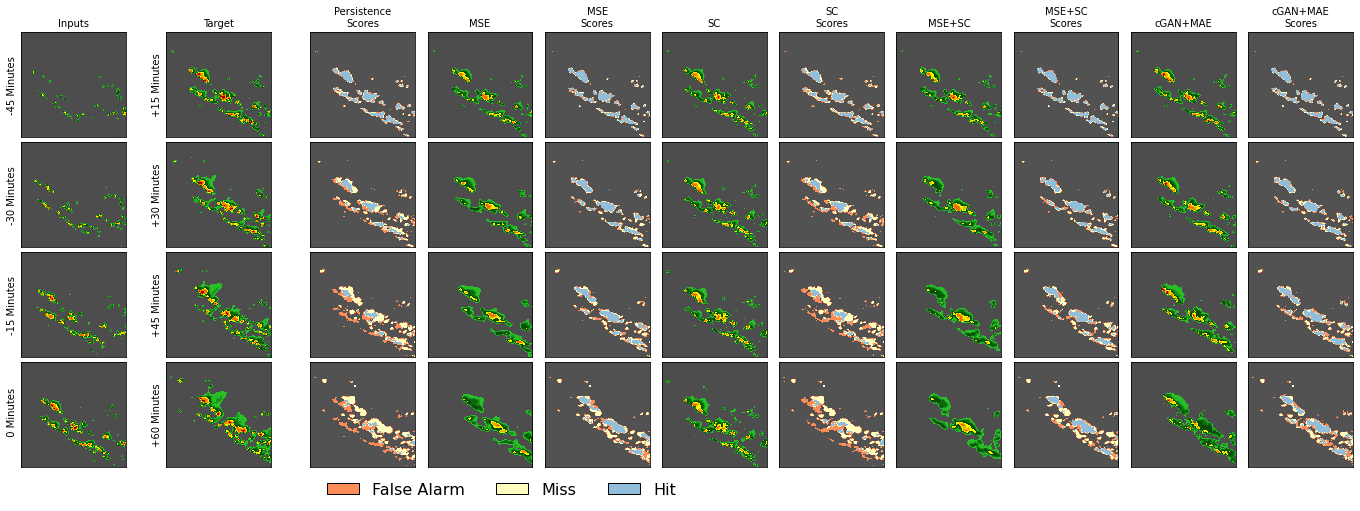

In [7]:
idx=25 # adjust this to pick a case
fig,ax = plt.subplots(4,13,figsize=(24,8), gridspec_kw={'width_ratios': [1,.2,1,.2,1,1,1,1,1,1,1,1,1]})
visualize_result([mse_model,style_model,mse_style_model,gan_model],x_test,y_test,idx,ax,labels=['MSE','SC','MSE+SC','cGAN+MAE'])

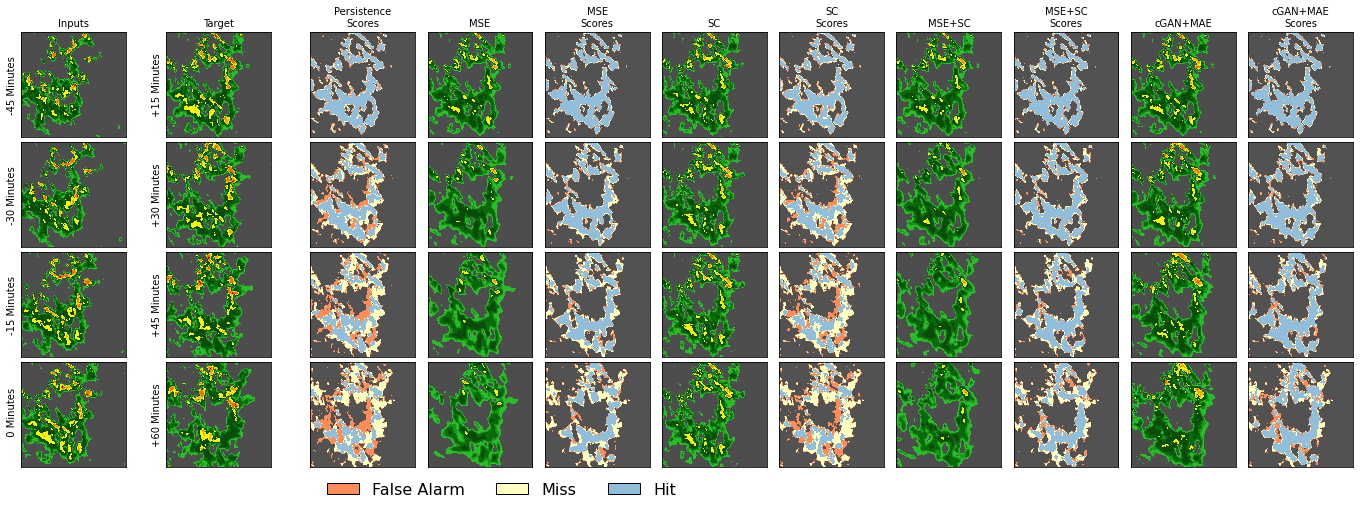

In [8]:
idx=45 # adjust this to pick a case
fig,ax = plt.subplots(4,13,figsize=(24,8), gridspec_kw={'width_ratios': [1,.2,1,.2,1,1,1,1,1,1,1,1,1]})
visualize_result([mse_model,style_model,mse_style_model,gan_model],x_test,y_test,idx,ax,labels=['MSE','SC','MSE+SC','cGAN+MAE'])

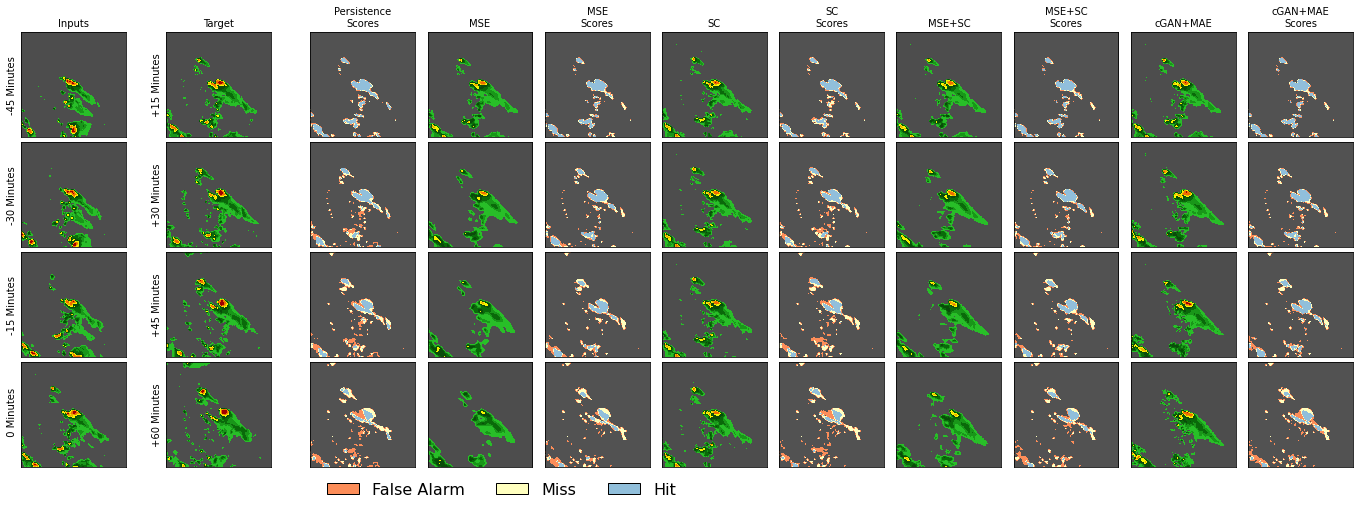

In [9]:
idx=32 # adjust this to pick a case
fig,ax = plt.subplots(4,13,figsize=(24,8), gridspec_kw={'width_ratios': [1,.2,1,.2,1,1,1,1,1,1,1,1,1]})
visualize_result([mse_model,style_model,mse_style_model,gan_model],x_test,y_test,idx,ax,labels=['MSE','SC','MSE+SC','cGAN+MAE'])